# IBM Receipt Recognition

#### Objective: Extract Total Amount, Date and Expense Type from Image of Receipt (Paper or Digital)

#### Libaries
- Gensim (word2Vec): Word Embeddings/Semantics
- SciKit Learn: Word Vectorization
- Spacy, NLTK: Natural Language Processing
- TensorFlow/SciKit Learn: Machine Learning Models
- Microsoft Azure API (OCR): Image to Json for Text Conversion
- Jupyter Notebooks: Development Environment

![alt text](test/img17.jpg "Title")

#### Steps
- <b>Step 1:</b> Collect a large data set of receipts, ideally both email and paper receipts. (See possible links below). This data will very likely need to be cleaned.
 *Consider Standardization of receipt inputs. Receipt images may be slanted, tilted, or zoomed out, etc. If OCR performance is reduced because of the format of the images then we may want to find some way to standardize (remove the background and straighten out the image) for optimal OCR results.
- <b>Step 2:</b> Use Azure OCR to convert out cleaned receipt dataset into JSON Files.
- <b>Step 3:</b> Use Spacy Natural Language Processing to parse JSON text. 
Finding Date and Total: Text can be parse using Regular Expressions. Create multiple spacy ‘Patterns’ to catch when parsing. 
Finding Expense Type: 
<ul>
<li>Approach 1: Load Spacy’s preloaded semantic vocabulary. Calculate the average word vector for the purchased items. Find which category(‘Food’, ‘Parking’, “Gas”) the average word vector has the least distance to.</li>
<li>Approach 2: Create a classifier (Naive Bayes, SVM, DTrees, etc) that classifies the text of common receipt types. Requires the dataset to be labelled by type. Receipt text will need to be vectorized using Scikit Learn before use of machine learning. </li>
<li>Approach 3: Ensemble Approach; use a combination of models and vector calculations to classify expense type. (Typically leads to the highest accuracy)</li>
</ul>

#### Milestones
1. Cleaned Dataset that is Large and Diverse (Contains both paper and digital receipts of various expense types)
2. Successful Image to Text Conversion
3. Date Identification
4. Total Amount Identification
5. Expense Type Identification

# Step 1: Data Collection

In [3]:
expense_types = ['Airfare', 'Car Rental', 'Hotel', 'Fuel', 'Parking', 'Taxi', 'Toll', 'Train', 'Maintenance',
                 'Breakfast', 'Meal', 'Dinner', 'Lunch', 'Groceries', 'Coffee', 'Entertainment', 'Office Supplies', 'Software',
                 'Online Fees', 'Mobile', 'Cellular Phone']

# Step 2: Image-to-Text - Azure

### Imports

In [6]:
### Importsimport requests
import requests
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
from io import BytesIO
import json
import ast


### Functions

In [7]:
# Extract the word bounding boxes and text.
# Returns an Array That Contains a Dictionary with Bounding Box
# Coordinates and the Text Labels
def extract_word_info(line_infos):
    word_infos = []
    for line in line_infos:
        for word_metadata in line:
            for word_info in word_metadata["words"]:
                word_infos.append(word_info)
    return word_infos

In [8]:
# Save Output
# Saves a Text File That Contains Information of the Word Bounding Boxes and Text Labels
def save_output(word_infos, file_name="output"):
    words = []
    for i in word_infos: words.append(str(i))
    with open("text/" + file_name + ".txt", "w") as f:
        for line in words:
            f.write("%s\n" % line)

In [9]:
# Save Json Output
# Saves a Text File that contains the Json Output from Microsoft Azure
def save_json(json_data, file_name="json"):
    #print(json_data)
    type(json_data)
    with open('json/' + file_name + '.txt', 'w') as outfile:
        outfile.write(json.dumps(json_data))

In [10]:
# Display the image and overlay it with the extracted text.
def create_image(image_url, word_infos, save=False, img_name="img"):
    plt.figure(figsize=(30, 30))
    image = Image.open(BytesIO(requests.get(image_url).content))
    ax = plt.imshow(image, alpha=0.5)
    for word in word_infos:
        bbox = [int(num) for num in word["boundingBox"].split(",")]
        text = word["text"]
        origin = (bbox[0], bbox[1])
        patch  = Rectangle(origin, bbox[2], bbox[3], fill=False, linewidth=2, color='y')
        ax.axes.add_patch(patch)
        plt.text(origin[0], origin[1], text, fontsize=20, weight="bold", va="top")
    plt.axis("off")
    if save: plt.savefig('img/' + img_name + '.jpg')

In [11]:
# ENTER YOUR MICROSOFT SUBSCRIPTION KEY
subscription_key = ""
image_url = ""
vision_base_url = ""

def receipt_ocr(img_id, sub_key=subscription_key, save=True):
    img_id = str(img_id)
    print("Currently Processing: " + img_id + ".jpg")
    # Setup Key and Vision Base URL
    subscription_key = sub_key
    assert subscription_key
    vision_base_url = vision_base_url
    ocr_url = vision_base_url + "ocr"
    # Set up API Request Parameters
    image_url = image_url + img_id + ".jpg"
    headers = {'Ocp-Apim-Subscription-Key': subscription_key}
    params  = {'language': 'unk', 'detectOrientation': 'true'}
    data    = {'url': image_url}
    response = requests.post(ocr_url, headers=headers, params=params, json=data)
    response.raise_for_status()
    analysis = response.json()
    save_json(analysis, img_id)
    # Extract Word Information form JSON
    line_infos = [region["lines"] for region in analysis["regions"]]
    word_infos = extract_word_info(line_infos)
    # Save a Txt File With Word Info
    save_output(word_infos, img_id)
    # Save the Annotated Image
    create_image(image_url, word_infos, save=save, img_name=img_id)

# Step 3: Natural Language Processing

### Imports

In [12]:
# Import Standard Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set()

In [13]:
# Import Spacy
import re
import string
import spacy
from spacy import displacy
# Prereq: python -m spacy download en_core_web_lg
nlp = spacy.load('en_core_web_lg')

In [14]:
# Import NLTK
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /Users/DJ/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/DJ/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Text Formatting and Cleaning

In [108]:
# Remove Punctuation
# param text (arr) - Text to Clean
def remove_punc(text):
    return re.sub(r'[^\w\s]','',text)

# Remove Words that are Numbers from a List
# param text (arr) - List of Words
def remove_num(text):
    return [w for w in text if not w.isdigit()]

# Tokenize Words
# param text (arr) - List of Words
def tokenize_words(text):
    return word_tokenize(' '.join(text))

# Remove Stop Words
# param text (arr) - List of Words
def remove_stop(text):
    stop_words = set(stopwords.words('english'))
    return [w for w in text if not w in stop_words]

# Remove Custom Stop Words
# param text (arr) - List of Words
def remove_custom_stop(text):
    custom_stop_words = ['visit', 'back', 'visa', 'change', 'thanks', 'survey', 'total', 'tax',
                         'coupon', 'invalid', 'details', 'your', 'emp', 'rewards', 'please',
                         'see', 'register', 'order', 'take', 'again', 'our', 'subtotal', 'for',
                         'rebate', 'cash', 'website', 'id', 'come', 'tendered', 'building', 'street']
    return [w for w in text if not w in custom_stop_words]

# Filter for only Nouns
# param text (arr) - List of Words
def remove_non_nouns(text):
    return [w for w in text if nlp(w)[0].pos_ == 'NOUN']

# Remove Meaningless Words
# param text (arr) - List of Words
# param report (bool) - Print Number of Removed Words
def remove_meaningless(text, report=True):     
    cleaned = [w for w in text if not nlp(w).vector_norm == 0]
    if report: print('Removed ' + str(len(text) - len(cleaned)) + ' word(s) out of ' + str(len(text)))
    return cleaned
    

# Extrats Text from the Formatted Text Output of Azure Text Detection
# param text_id (str) - ID of the text
def extract_text(text_id):
    file = open('text/' + str(text_id) +'.txt', 'r')
    text = file.readlines()
    words = []
    for i in text:
        word = ast.literal_eval(i)["text"]
        word = remove_punc(word)
        if word != '': words.append(word.lower())
    return words

# Extract and Clean Text
# param text_id (str) - ID of the text
def format_text(text_id):
    text = extract_text(text_id)
    print(text)
    text = remove_num(text)
    text = tokenize_words(text)
    text = remove_stop(text)
    text = remove_custom_stop(text)
    text = remove_meaningless(text)
    return text

### Word Vector (TSNE) Visualization

In [16]:
from sklearn.manifold import TSNE

import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

In [17]:
# Reduce the Dimensionality of the Word Embeddings
# Uses Preloaded Spacy Vectors
# param text (arr) - List of Words
def tsne_fit(text, dim=2):
    tokens = [nlp(w).vector for w in text ]
    tsne_model = TSNE(perplexity=40, n_components=dim, init='pca', n_iter=2500, random_state=23)
    return tsne_model.fit_transform(tokens)

# Conduct TSNE on Types and Additional Text
# param types (arr) - List of Categories
# param text (arr) - List of Additional words
# return types (arr), text (arr) - post-TSNE Values
def types_text_tsne(types, text, dim=2):
    tokens = tsne_fit(types + text, dim=dim)
    return tokens[:len(types)], tokens[len(types):]

In [18]:
# 2D Plot of Expense Types and Words (Word Embeddings)
# param types (arr) - Classification Types
# param text (arr) - Additional Words
# param avg_vect (bool) - Whether the average word vector should be plotted
def tsne_plot_2d(types, text=None, avg_vect=False):
    
    title='Types and Words'
    # Get the Reduced TSNE Values
    types_arr_2d = tsne_fit(types, dim=2) 
    text_arr_2d = []
    if text: 
        types_arr_2d, text_arr_2d = types_text_tsne(types, text, dim=2)
        title='Types'
        
    x,y = np.array(types_arr_2d).transpose()

    trace1 = go.Scatter(
        x=x,
        y=y,
        marker=dict(
            size=5,
            line=dict(
                color='rgba(217, 217, 217, 0.14)',
                width=0.5
            ),
            opacity=0.8
        ),
        mode='markers+text',
        name='Types',
        text= types,
        textposition='top right',
        textfont=dict(
            family='sans serif',
            size=12,
            color='#1f77b4'
        )
    )
    if text:
        x2,y2 = np.array(text_arr_2d).transpose()
        trace2 = go.Scatter(
            x=x2,
            y=y2,
            marker=dict(
                color='rgb(127, 127, 127)',
                size=5,
                symbol='circle',
                line=dict(
                    color='rgb(204, 204, 204)',
                    width=1
                ),
                opacity=0.9
            ),
            mode='markers+text',
            name='Words',
            text= text,
            textposition='top right',
            textfont=dict(
                family='sans serif',
                size=12,
                color='rgb(127, 127, 127)'
            )
        )
    
    if text and avg_vect:
        x3,y3 = [], []
        avg_vector = np.average(np.array(text_arr_2d).transpose(), axis=1)
        x3.append(avg_vector[0])
        y3.append(avg_vector[1])
        trace3 = go.Scatter(
            x=x3,
            y=y3,
            marker=dict(
                color='rgb(220, 20, 60)',
                size=7,
                symbol='circle',
                line=dict(
                    color='rgb(220, 20, 60)',
                    width=1
                ),
                opacity=0.9
            ),
            mode='markers+text',
            name='Average Word Vector',
            text= ['AVG VECTOR'],
            textposition='top right',
            textfont=dict(
                family='sans serif',
                size=12,
                color='rgb(220, 20, 60)'
            )
        )

        
    # Include Trace Into Data Variable
    data = [trace1]
    if text and not avg_vect: data = [trace1, trace2]
    elif text and avg_vect: data = [trace1, trace2, trace3]
        
    layout = go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )
    layout = go.Layout(
        title='Types'
    )
    fig = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(fig, filename='types-and-words')

In [19]:
# 3D Plot of Expense Types and Words (Word Embeddings)
# param types (arr) - Classification Types
# param text (arr) - Additional Words
# param avg_vect (bool) - Whether the average word vector should be plotted
def tsne_plot_3d(types, text=None, avg_vect=False):
    
    title='Types and Words'
    # Get the Reduced TSNE Values
    types_arr_2d = tsne_fit(types, dim=3) 
    text_arr_2d = []
    if text: 
        types_arr_2d, text_arr_2d = types_text_tsne(types, text, dim=3)
        title='Types'
        
    x,y,z = np.array(types_arr_2d).transpose()
    trace1 = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        marker=dict(
            size=5,
            line=dict(
                color='rgba(217, 217, 217, 0.14)',
                width=0.5
            ),
            opacity=0.8
        ),
        mode='markers+text',
        name='Types',
        text= types,
        textposition='top right',
        textfont=dict(
            family='sans serif',
            size=12,
            color='#1f77b4'
        )
    )
    if text:
        x2,y2,z2 = np.array(text_arr_2d).transpose()
        trace2 = go.Scatter3d(
            x=x2,
            y=y2,
            z=z2,
            marker=dict(
                color='rgb(127, 127, 127)',
                size=5,
                symbol='circle',
                line=dict(
                    color='rgb(204, 204, 204)',
                    width=1
                ),
                opacity=0.9
            ),
            mode='markers+text',
            name='Words',
            text= text,
            textposition='top right',
            textfont=dict(
                family='sans serif',
                size=12,
                color='rgb(127, 127, 127)'
            )
        )
        
    if text and avg_vect:
        x3,y3, z3 = [], [], []
        avg_vector = np.average(np.array(text_arr_2d).transpose(), axis=1)
        x3.append(avg_vector[0])
        y3.append(avg_vector[1])
        z3.append(avg_vector[2])
        trace3 = go.Scatter3d(
            x=x3,
            y=y3,
            z=z3,
            marker=dict(
                color='rgb(220, 20, 60)',
                size=7,
                symbol='circle',
                line=dict(
                    color='rgb(220, 20, 60)',
                    width=1
                ),
                opacity=0.9
            ),
            mode='markers+text',
            name='Average Word Vector',
            text= ['AVG VECTOR'],
            textposition='top right',
            textfont=dict(
                family='sans serif',
                size=12,
                color='rgb(220, 20, 60)'
            )
        )

    # Include Trace Into Data Variable
    data = [trace1]
    if text and not avg_vect: data = [trace1, trace2]
    elif text and avg_vect: data = [trace1, trace2, trace3]
        
    layout = go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )
    layout = go.Layout(
        title=title
    )
    fig = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(fig, filename='types-and-words')
    
#tsne_plot_3d(expense_types, text, avg_vect=True)

### Similarity Matrix Visualization

In [20]:
# Finds the Most Similar Expense Type
# param types (arr) - List of Expense Types
# param text (arr) - Array of Text
def get_sim_matrix(types, text):
    sim_matrix = []
    for word in text:
        word_sim = []
        for exp_type in types: word_sim.append(nlp(word).similarity(nlp(exp_type)))
        sim_matrix.append(word_sim)
    return sim_matrix

# Plots a Heatmap of the Similarity Matrix
# param sim_matrix (arr 2d) - Contains similarities x=types, y=text
# param x_labels (arr) - Types
# param y_labels (arr) - Text
def plot_sim_matrix(sim_matrix, x_labels, y_labels):
    fig_height = max(5, round(5 * len(y_labels)/len(x_labels), 1))
    with sns.axes_style("white"):
        plt.figure(figsize=(5, fig_height))
        plt.title('Similarity Matrix - Words and Expense Types')
        ax = sns.heatmap(sim_matrix, vmax=1, vmin=0, cmap="Reds", xticklabels=x_labels, yticklabels=y_labels)
        plt.show()
        
# Calculate and Plots Sim Matrix
# param types (arr) - List of Expense Types
# param text (arr) - Array of Text
def calc_plot_sim_matrix(types, text):
    sim_matrix = get_sim_matrix(types, text)
    plot_sim_matrix(sim_matrix, types, text)

### Categorization by Average Vector Functions

In [21]:
# Get the Avg Vector of Text
# param text (arr) - Text to Avg
# return avg_vect (arr) - Averaged Vector of Text
def avg_vect(text):
    return nlp(' '.join(text))

# Finds the Most Similar Expense Type
# param types (arr) - List of Expense Types
# param text (arr) - Array of Text
def most_similar_by_avg(types, text):
    avg_vector = avg_vect(text)
    closest_type = ''
    closest_score = 0
    for i in types:
        #print(str(round(avg_vector.similarity(nlp(i)), 2)) + ' ' + i)
        similarity = avg_vector.similarity(nlp(i))
        if(similarity > closest_score):
            closest_score = similarity
            closest_type = i
    closest_score = round(closest_score * 100, 3)
    return closest_type, closest_score  

# Plots Type Similarity Using the Avg Word Vector
# types (arr) - List of Expense Types
def plot_similar_by_avg(types, text, text_id=''):
    avg_vector = avg_vect(text)
    sim = []
    for i in types: sim.append(avg_vector.similarity(nlp(i)))
    sns.barplot(types, sim, alpha=0.9).set_xticklabels(types, rotation=90)
    plt.xlabel('Category')
    plt.ylabel('Similarity')
    plt.title('Similarities by Expense Types for Receipt '+ str(text_id))
    plt.show()

### Date Extraction

In [22]:
import datefinder

In [23]:
# Given string of text extracted from the receipt, Identify the date of Purchase
# Returns the First Date Object Found
# param text (arr) - List of Words
def date_find(text):
    sentence = ' '.join(text)
    matches = datefinder.find_dates(sentence)
    dates = [i for i in matches]
    if(len(dates) == 0): return None
    else: return dates[0]

# Step 3: Natural Language Processing

### Imports

In [24]:
from PIL import Image
from IPython.display import HTML
from io import BytesIO
from base64 import b64encode

### Functions

In [25]:
# Print Image into Notebook
# param path (str) - path to image
def display_img(path):
    pil_im = Image.open(path)
    b = BytesIO()  
    pil_im.save(b, format='png')
    display(HTML("<img src='data:image/png;base64,{0}' />".format(b64encode(b.getvalue()).decode('utf-8'))))

#### Analyze Receipts

In [110]:
receipts_list = [19, 29, 33, 34, 36, 37, 38, 40, 42, 43, 45, 46, 50, 51, 52, 53]
short_list = [18, 19, 29, 33, 34]

In [38]:
# pip install pyttsx3 pypiwin32
import pyttsx3
import time
import optparse

In [39]:
# One time initialization
engine = pyttsx3.init()

# Set properties _before_ you add things to say
engine.setProperty('rate', 150)    # Speed percent (can go over 100)
engine.setProperty('volume', 0.9)  # Volume 0-1

In [116]:
def demo():
    
    display_img('original_img/19.jpg')
    
    engine.say("Analyzing Receipt")

    engine.say("Receipt Analyzed")
    
    display_img('img/19.jpg')
    
    engine.say("This receipt Was a meal expense for a total amount of 14 dollars and 10 cents.")

    # Flush the say() queue and play the audio
    engine.runAndWait()
    
    text = format_text(19)
    print(text)
    print(most_similar_by_avg(expense_types, text))
    print('TEXT: ' + ' '.join(text))
    #tsne_plot_3d(expense_types, text, avg_vect=True)
    calc_plot_sim_matrix(expense_types, text)
    plot_similar_by_avg(expense_types, text, i)

Analyzing Receipt #19



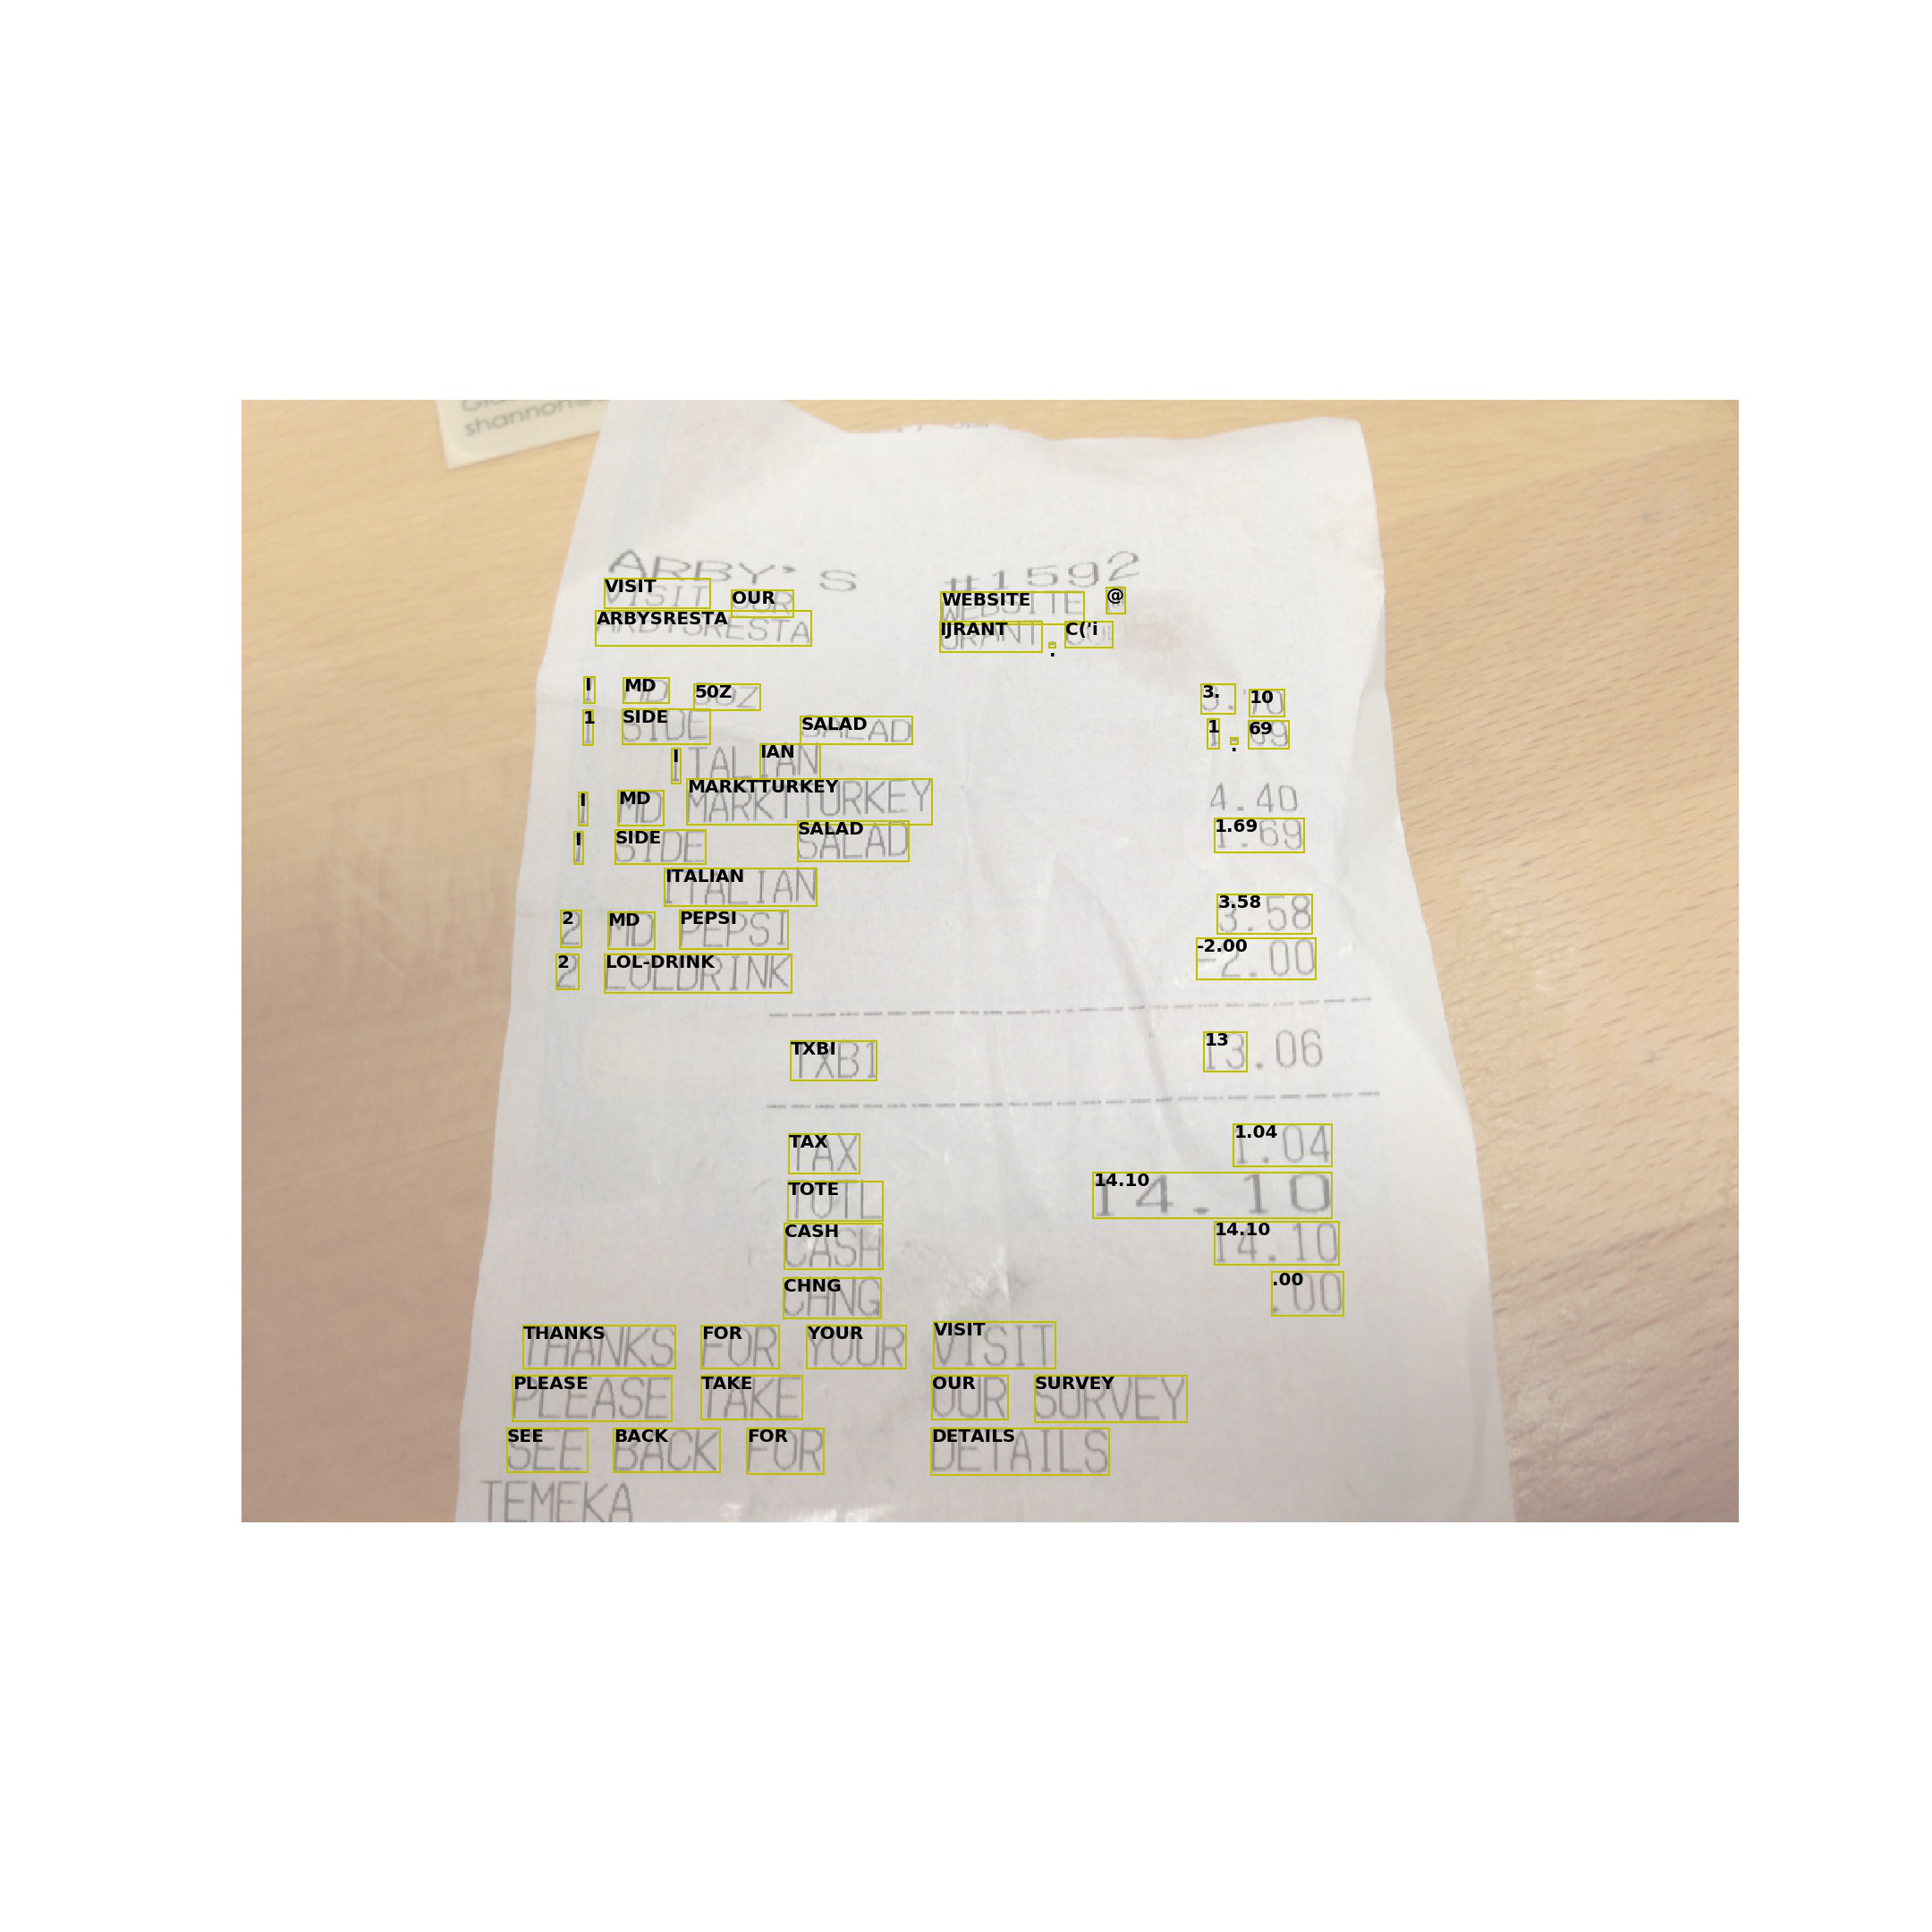

['visit', 'our', 'website', 'arbysresta', 'ijrant', 'ci', 'i', 'md', '50z', '3', '10', '1', 'side', 'salad', 'i', 'ian', 'i', 'md', 'marktturkey', 'salad', 'i', 'side', 'italian', '2', 'md', 'pepsi', '2', 'loldrink', 'txbi', 'tax', 'tote', 'cash', 'chng', '1', '69', '169', '358', '200', '13', '104', '1410', '1410', '00', 'thanks', 'for', 'your', 'visit', 'please', 'take', 'our', 'survey', 'see', 'back', 'for', 'details']
Removed 7 word(s) out of 19
['ci', 'md', 'side', 'salad', 'ian', 'md', 'salad', 'side', 'italian', 'md', 'pepsi', 'tote']
('Dinner', 44.657)
TEXT: ci md side salad ian md salad side italian md pepsi tote


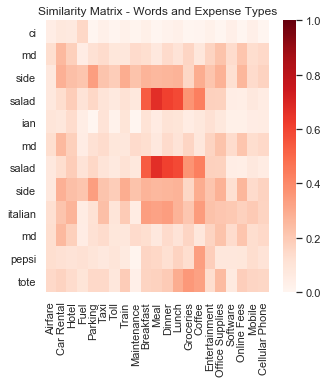

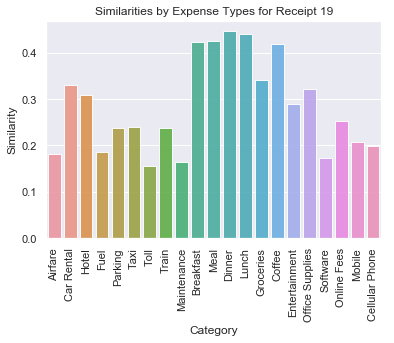

Analyzing Receipt #29



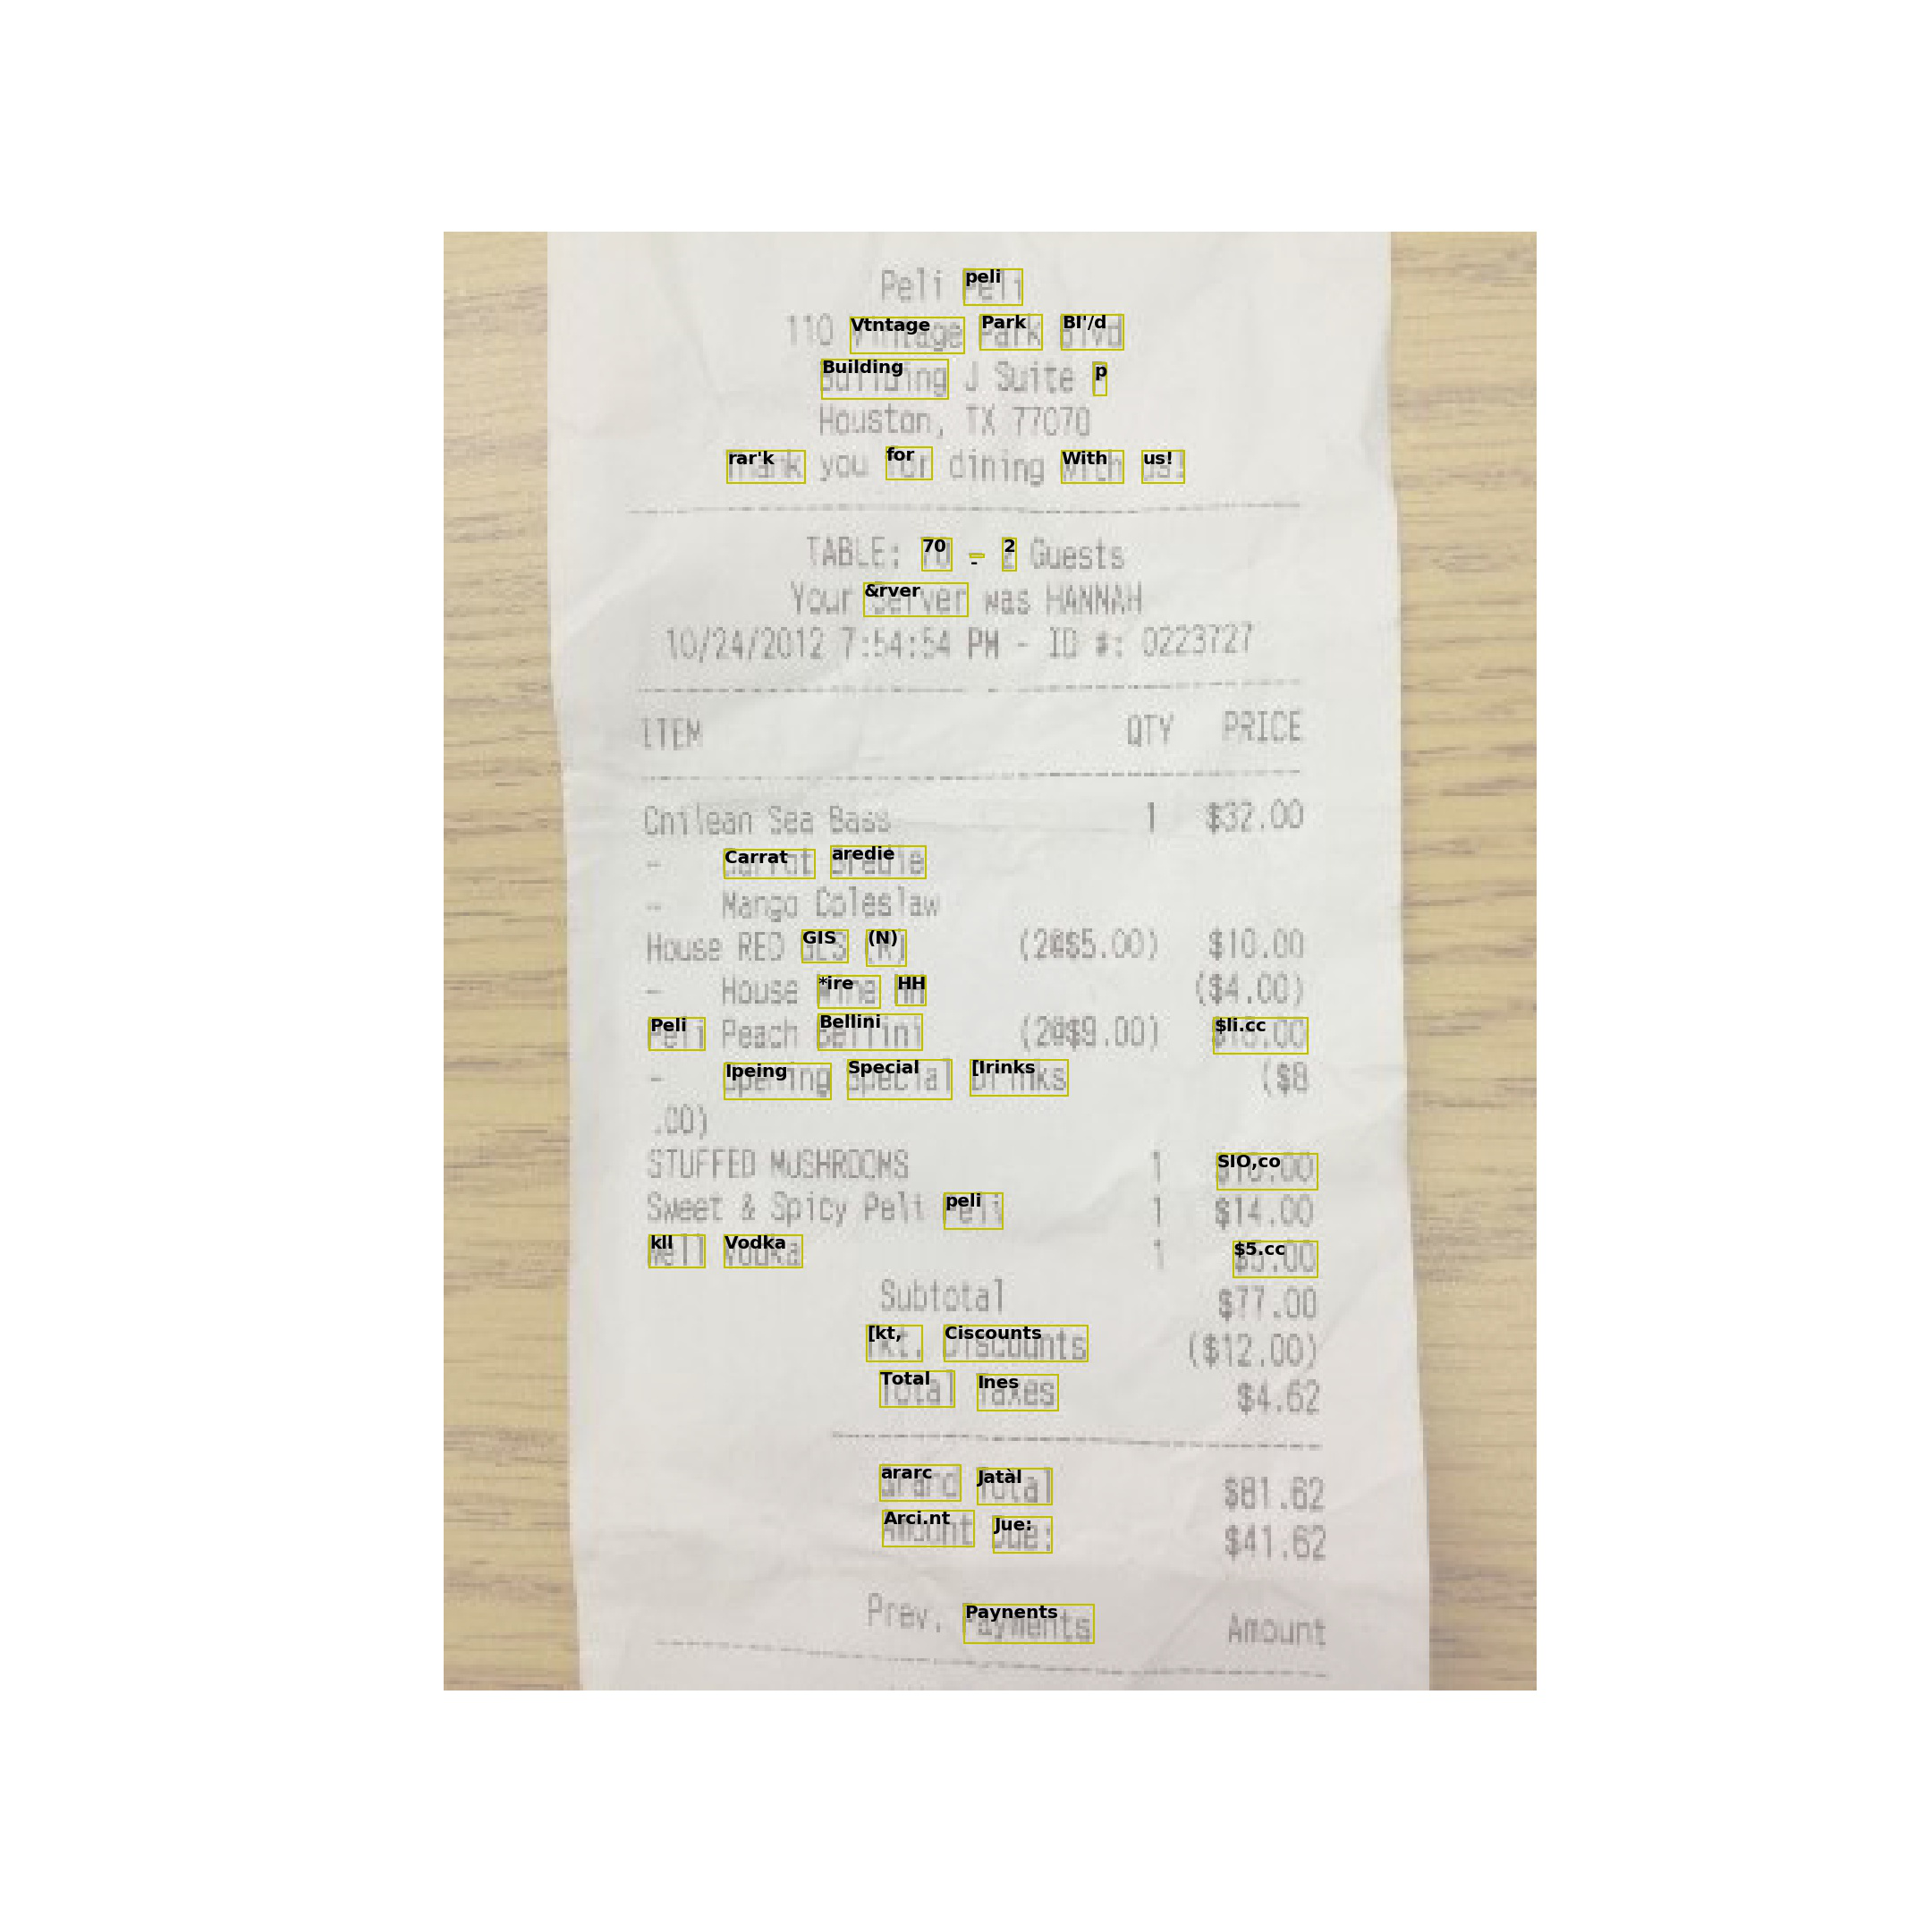

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe0 in position 1618: invalid continuation byte

In [111]:
for i in receipts_list:
    print('Analyzing Receipt #' + str(i))
    display_img('img/' + str(i) + '.jpg')
    text = format_text(i)
    print(text)
    print(most_similar_by_avg(expense_types, text))
    print('TEXT: ' + ' '.join(text))
    tsne_plot_2d(expense_types, text, avg_vect=True)
    calc_plot_sim_matrix(expense_types, text)
    plot_similar_by_avg(expense_types, text, i)


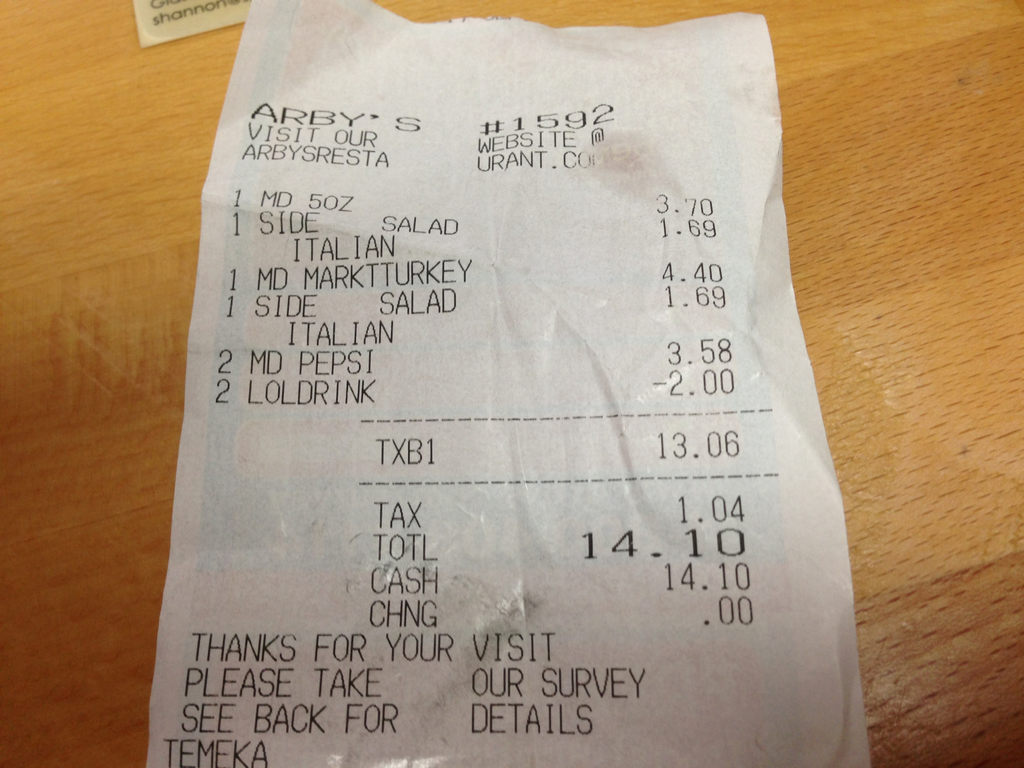


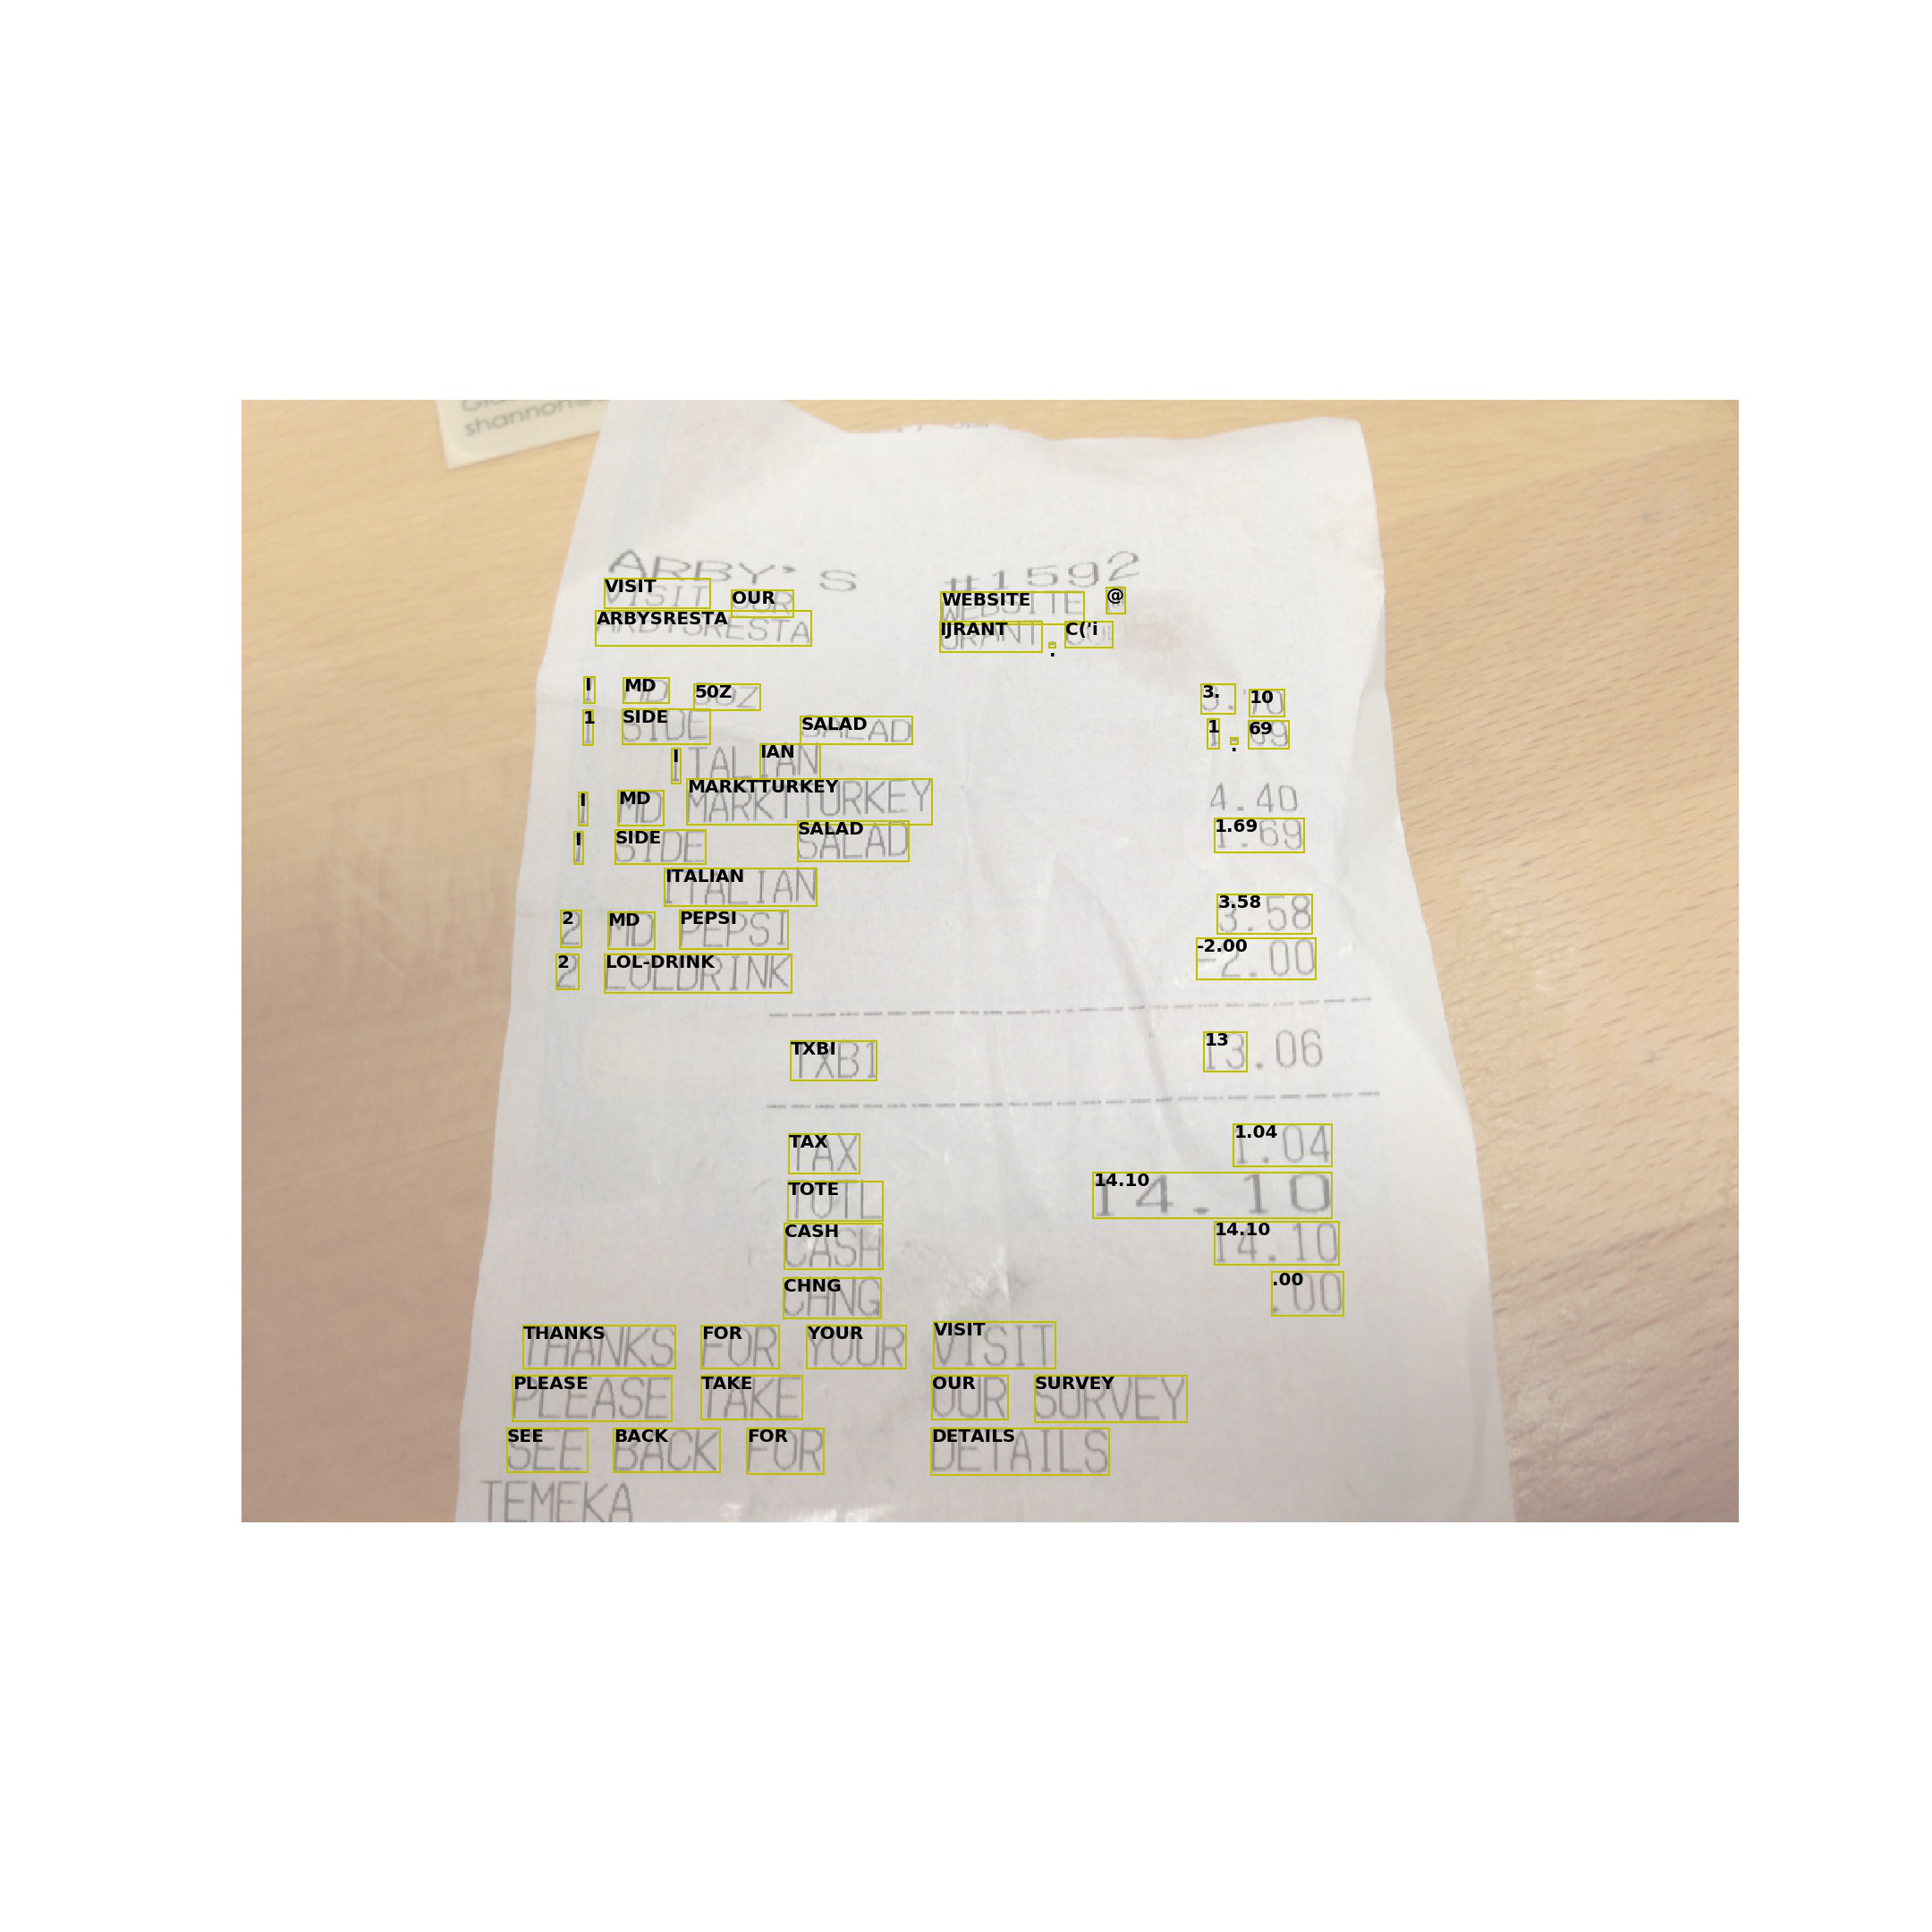

['visit', 'our', 'website', 'arbysresta', 'ijrant', 'ci', 'i', 'md', '50z', '3', '10', '1', 'side', 'salad', 'i', 'ian', 'i', 'md', 'marktturkey', 'salad', 'i', 'side', 'italian', '2', 'md', 'pepsi', '2', 'loldrink', 'txbi', 'tax', 'tote', 'cash', 'chng', '1', '69', '169', '358', '200', '13', '104', '1410', '1410', '00', 'thanks', 'for', 'your', 'visit', 'please', 'take', 'our', 'survey', 'see', 'back', 'for', 'details']
Removed 7 word(s) out of 19
['ci', 'md', 'side', 'salad', 'ian', 'md', 'salad', 'side', 'italian', 'md', 'pepsi', 'tote']
('Dinner', 44.657)
TEXT: ci md side salad ian md salad side italian md pepsi tote


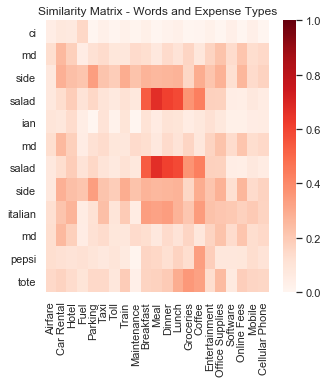

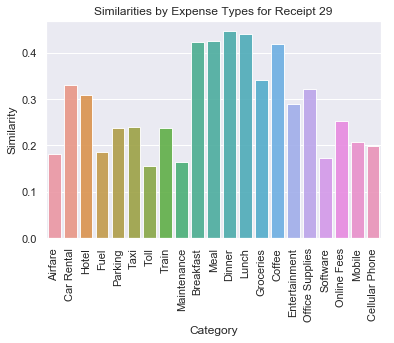

In [121]:
demo()